In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

In [ ]:
import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.callbacks import EarlyStopping

In [ ]:
###mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read the stock price data

In [ ]:
stock_df= pd.read_csv('./drive/My Drive/Colab Notebooks/GME_stock.csv',parse_dates=["date"])

In [ ]:
stock_df.tail()

,date,open_price,high_price,low_price,close_price,volume,adjclose_price
4768,2002-02-20,9.600,9.875,9.525,9.875,1723200.0,6.648838
4769,2002-02-19,9.900,9.900,9.375,9.550,1852600.0,6.430017
4770,2002-02-15,10.000,10.025,9.850,9.950,2097400.0,6.699336
4771,2002-02-14,10.175,10.195,9.925,10.000,2755400.0,6.733003
4772,2002-02-13,9.625,10.060,9.525,10.050,19054000.0,6.766666


In [ ]:
stock_df.head()

,date,open_price,high_price,low_price,close_price,volume,adjclose_price
0,2021-01-28,265.000000,483.000000,112.250000,193.600006,58815800.0,193.600006
1,2021-01-27,354.829987,380.000000,249.000000,347.510010,93396700.0,347.510010
2,2021-01-26,88.559998,150.000000,80.199997,147.979996,178588000.0,147.979996
3,2021-01-25,96.730003,159.179993,61.130001,76.790001,177874000.0,76.790001
4,2021-01-22,42.590000,76.760002,42.320000,65.010002,196784300.0,65.010002


The data has inverted order by date. We need to change it in  date ascending order.

In [ ]:
stock_df=stock_df.sort_values(by="date", ascending=True)
stock_df.reset_index(inplace=True)
stock_df.set_index('date',inplace=True)

In [ ]:
stock_df.head()

,index,open_price,high_price,low_price,close_price,volume,adjclose_price
date,,,,,,,
2002-02-13,4772,9.625,10.060,9.525,10.050,19054000.0,6.766666
2002-02-14,4771,10.175,10.195,9.925,10.000,2755400.0,6.733003
2002-02-15,4770,10.000,10.025,9.850,9.950,2097400.0,6.699336
2002-02-19,4769,9.900,9.900,9.375,9.550,1852600.0,6.430017
2002-02-20,4768,9.600,9.875,9.525,9.875,1723200.0,6.648838


data preprocessing for RNN model

In [ ]:
## take close_price as target
close_price=stock_df[['close_price']]
close_price.shape

(4773, 1)

In [ ]:
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
# scaler_X = MinMaxScaler()
# scaler_Y = MinMaxScaler()

In [ ]:
X_scaled = scaler_X.fit_transform(stock_df)
Y_scaled = scaler_Y.fit_transform(close_price)

In [ ]:
def convert2matrix(X_data_arr,Y_data_arr,look_back):
 X, Y =[], []
 for i in range(len(X_data_arr)-look_back):
  d=i+look_back  
  X.append(X_data_arr[i:d,1:])
  Y.append(Y_data_arr[d,])
 return np.array(X), np.array(Y)

In [ ]:
look_back=4
X,Y=convert2matrix(X_scaled,Y_scaled,look_back=look_back)  ## will look back previous 4 days' data

In [ ]:
X.shape

(4769, 4, 6)

In [ ]:
Y.shape

(4769, 1)

In [ ]:
train_size=ceil(X.shape[0]*0.8)
trainX,testX=X[0:train_size],X[train_size:]
trainY,testY=Y[0:train_size],Y[train_size:]

In [ ]:
train_size

3816

In [ ]:
trainX.shape , trainY.shape

((3816, 4, 6), (3816, 1))

In [ ]:
testX.shape, testY.shape

((953, 4, 6), (953, 1))

Below extract the date information in training and test dataset:

In [ ]:
dates_training = pd.to_datetime(stock_df.index[3:train_size+3])
dates_test = pd.to_datetime(stock_df.index[train_size+3:-1])

In [ ]:
dates_training.shape, dates_test.shape

((3816,), (953,))

**Build simpleRNN model**

In [ ]:
def model_rnn(look_back):
  model=Sequential()
  model.add(SimpleRNN(units=64,input_shape=(look_back,6),activation='relu',return_sequences = True,recurrent_dropout=0.2))
  model.add(SimpleRNN(units=64,activation='relu',return_sequences = True,recurrent_dropout=0.2))
  model.add(SimpleRNN(units=64,activation='relu',recurrent_dropout=0.2))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mse','mae'])
  return model

In [ ]:
model=model_rnn(4)
model.summary()
# history=model.fit(trainX,trainY,
#                   epochs=100,
#                   batch_size=32,
#                   verbose=1,
#                   validation_data=(testX,testY),
#                   callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
#                   shuffle=False)
history=model.fit(trainX,trainY,
                  epochs=100,
                  batch_size=32,
                  verbose=1,
                  validation_data=(testX,testY),
                  shuffle=False)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_24 (SimpleRNN)    (None, 4, 64)             4544      
_________________________________________________________________
simple_rnn_25 (SimpleRNN)    (None, 4, 64)             8256      
_________________________________________________________________
simple_rnn_26 (SimpleRNN)    (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 21,121
Trainable params: 21,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
120/120 [==============================] - 4s 10ms/step - loss: 0.1622 - mse: 0.1622 - mae: 0.2858 - val_loss: 0.5820 - val_mse: 0.5820 - val_mae: 0.1518
Epoch 2/100
120/120 [==============================] - 1s 6ms/step - loss: 0.0300 

In [ ]:
##model.save('/content/drive/MyDrive/simpleRNN_Model/RNN_1_model.h5')

In [ ]:
def model_loss(history):
  plt.figure(figsize=(8,4))
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Test Loss')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(loc='upper right')
  plt.show()

Train Root Mean Squared Error(RMSE): 0.09; Train Mean Absolute Error(MAE) : 0.07 
Test Root Mean Squared Error(RMSE): 0.53; Test Mean Absolute Error(MAE) : 0.06 


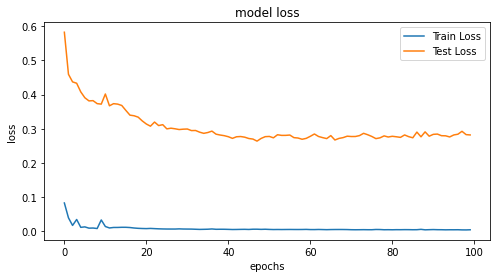

In [ ]:
train_score = model.evaluate(trainX,trainY, verbose=0)  
print('Train Root Mean Squared Error(RMSE): %.2f; Train Mean Absolute Error(MAE) : %.2f ' 
% (np.sqrt(train_score[1]), train_score[2]))  ###这里用了np.sqrt()
test_score = model.evaluate(testX,testY, verbose=0)
print('Test Root Mean Squared Error(RMSE): %.2f; Test Mean Absolute Error(MAE) : %.2f ' 
% (np.sqrt(test_score[1]), test_score[2]))
model_loss(history)

In [ ]:
def prediction_plot(Y_actual,Y_predict,title,dates):
  plt.figure(figsize=(11,7))
  Y_actual=pd.DataFrame(Y_actual,index=dates)
  Y_predict=pd.DataFrame(Y_predict,index=dates)
  plt.plot(Y_actual,color= 'blue',label='actual')
  plt.plot(Y_predict, color= 'red',label='prediction')
  #plt.tight_layout()
  #sns.despine(top=True)
  #plt.subplots_adjust(left=0.07)
  plt.ylabel('stock_price',size=15)
  plt.xlabel('Date',size=15)
  plt.legend(fontsize=15)
  plt.title('Tomorrow Stock Price Forecasting_'+title+'_via simpleRNN\n',size=15)
  plt.show()

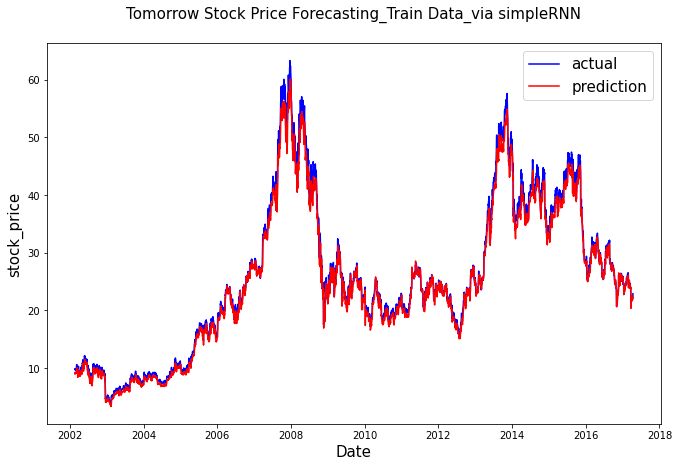

In [ ]:
train_predict=model.predict(trainX)
trainY_predict_value=scaler_Y.inverse_transform(train_predict)
trainY_actual_value=scaler_Y.inverse_transform(trainY)
prediction_plot(trainY_actual_value,trainY_predict_value,'Train Data',dates_training)


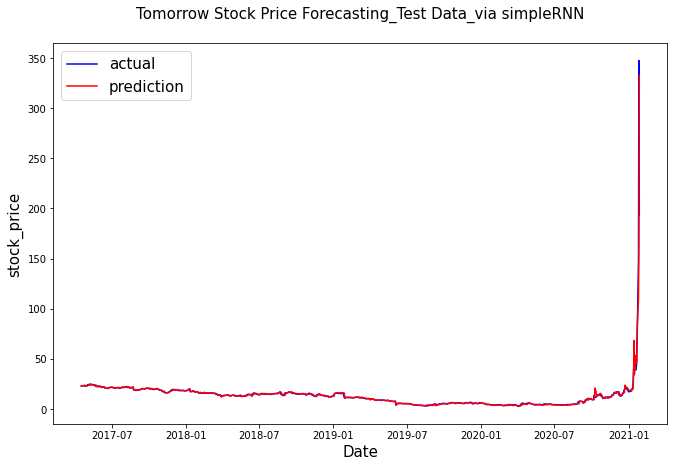

In [ ]:
test_predict=model.predict(testX)
testY_predict_value=scaler_Y.inverse_transform(test_predict)
testY_actual_value=scaler_Y.inverse_transform(testY)
prediction_plot(testY_actual_value,testY_predict_value,'Test Data',dates_test)


In [ ]:
testY_actual_value[0]

array([22.84000015])

In [ ]:
close_price[3816+3: 3822]

,close_price
date,
2017-04-17,22.889999
2017-04-18,22.840000
2017-04-19,22.780001


The Three metrics:

In [ ]:
RMSE_train = np.sqrt(mean_squared_error(trainY_actual_value,trainY_predict_value))
RMSE_test = np.sqrt(mean_squared_error(testY_actual_value,testY_predict_value))
print('The root mean square error (RMSE) for the train data is %.3f'%RMSE_train)
print('The root mean square error (RMSE) for the test data is %.3f'%RMSE_test)

The root mean square error (RMSE) for the train data is 1.311
The root mean square error (RMSE) for the test data is 7.705


In [ ]:
MAE_train = mean_absolute_error(trainY_actual_value,trainY_predict_value)
MAE_test = mean_absolute_error(testY_actual_value,testY_predict_value)
print('The mean absolute error (MAE) for the train data is %.3f'%MAE_train)
print('The mean absolute error (MAE) for the test data is %.3f'%MAE_test)

The mean absolute error (MAE) for the train data is 0.945
The mean absolute error (MAE) for the test data is 0.856


In [ ]:
R2_train = r2_score(trainY_actual_value,trainY_predict_value)
R2_test = r2_score(testY_actual_value,testY_predict_value)
print('The coefficient of determination (R^2) for the train data is %.3f'% R2_train)
print('The coefficient of determination (R^2) for the test data is %.3f'% R2_test)

The coefficient of determination (R^2) for the train data is 0.990
The coefficient of determination (R^2) for the test data is 0.730


In [ ]:
y_var_test=testY_actual_value[1:]-testY_actual_value[:len(testY_actual_value)-1]
y_var_predict=testY_predict_value[1:]-testY_predict_value[:len(testY_predict_value)-1]
txt=np.zeros(len(y_var_test))
for i in range(len(y_var_test)-1):
    txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
result=sum(txt)/len(txt)
print('Accuracy of price changing direction:',result)


Accuracy of price changing direction: 0.509453781512605


**Remove the last 11 data (they are increased suddenly)**

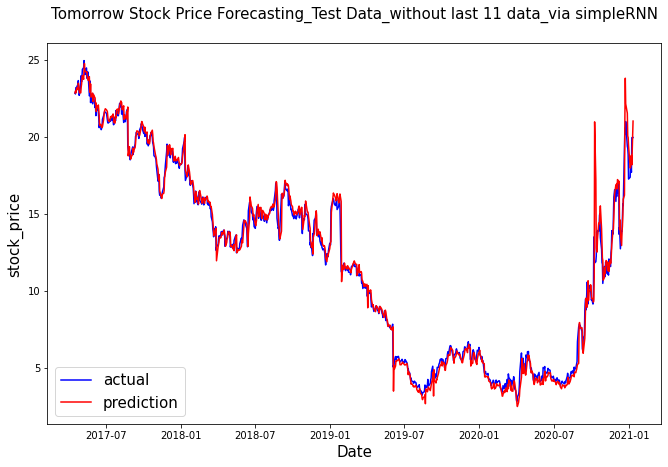

In [ ]:
prediction_plot(testY_actual_value[:-11],testY_predict_value[:-11],'Test Data_without last 11 data',dates_test[:-11])

In [ ]:
RMSE_test = np.sqrt(mean_squared_error(testY_actual_value[:-11],testY_predict_value[:-11]))
print('The root mean square error (RMSE) for the test data(without last 11 data) is %.3f'%RMSE_test)

The root mean square error (RMSE) for the test data(without last 11 data) is 0.669


In [ ]:
MAE_test = mean_absolute_error(testY_actual_value[:-11],testY_predict_value[:-11])
print('The mean absolute error (MAE) for the test data(without last 11 data) is %.3f'%MAE_test)

The mean absolute error (MAE) for the test data(without last 11 data) is 0.388


In [ ]:


R2_test = r2_score(testY_actual_value[:-11],testY_predict_value[:-11])
print('The coefficient of determination (R^2) for the test data(without last 11 data) is %.3f'% R2_test)

The coefficient of determination (R^2) for the test data(without last 11 data) is 0.988


In [ ]:
testY_actual_value=testY_actual_value[:-11]
testY_predict_value=testY_predict_value[:-11]
y_var_test=testY_actual_value[1:]-testY_actual_value[:len(testY_actual_value)-1]
y_var_predict=testY_predict_value[1:]-testY_predict_value[:len(testY_predict_value)-1]
txt=np.zeros(len(y_var_test))
for i in range(len(y_var_test)-1):
    txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
result=sum(txt)/len(txt)
print('Accuracy of price changing direction:',result)

Accuracy of price changing direction: 0.5090329436769394
